In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import glob
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelBinarizer

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
sess = tf.InteractiveSession()

In [4]:
x = tf.placeholder(tf.float32, [None, 784])
y_ = tf.placeholder(tf.float32, [None, 10])
W = tf.Variable(tf.zeros([784,10]))
b = tf.Variable(tf.zeros([10]))
sess.run(tf.global_variables_initializer())
y = tf.matmul(x,W) + b
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y, y_))
train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)
for i in range(1000):
    batch = mnist.train.next_batch(100)
    train_step.run(feed_dict={x: batch[0], y_: batch[1]})
correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print(accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))

0.9175


In [3]:
folders = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
img = None
xs, ys = list(), list()
# mx = 100000, Mx = 0, my = 100000, My = 0
# rescale to 720 x 1280
X, y = list(), list()
for fld in folders:
    img_paths = glob.glob('/'.join(['train', fld, '*.jpg']))
    index = folders.index(fld)
    for img_path in img_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img,(1280, 720), interpolation = cv2.INTER_CUBIC)
#         print(img.shape)
        X.append(img[:,:,0].reshape((1280 * 720, 1)))
        y.append(index)
    print("{0} images loaded from {1}.".format(len(X), fld))

1719 images loaded from ALB.
1919 images loaded from BET.
2036 images loaded from DOL.
2103 images loaded from LAG.
2568 images loaded from NoF.
2867 images loaded from OTHER.
3043 images loaded from SHARK.
3777 images loaded from YFT.


In [4]:
X, y = np.asarray(X), np.asarray(y)

In [5]:
y = LabelBinarizer().fit_transform(y)

In [6]:
print(X.shape)

(3777, 921600, 1)


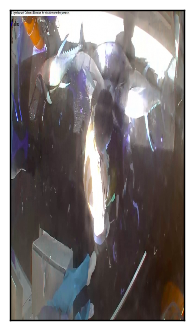

In [3]:
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [8]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev = 0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [9]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
x = tf.placeholder(tf.float32, shape=[None, 1280 * 720])
y_ = tf.placeholder(tf.float32, shape=[None, 8])

In [10]:
x_image = tf.reshape(x, [-1,720,1280,1])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

<h3>Second convolutional layer</h3>

In [11]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

<h3> Densely connected layer </h3>

In [12]:
W_fc1 = weight_variable([320 * 180 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 320 * 180 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

<h3> Dropout </h3>

In [13]:
keep_prob = tf.placeholder(tf.float32)
h_fc_drop = tf.nn.dropout(h_fc1, keep_prob)

In [14]:
W_fc2 = weight_variable([1024, 8])
b_fc2 = bias_variable([8])

y_conv = tf.matmul(h_fc_drop, W_fc2) + b_fc2

<h3> Training </h3>

In [ ]:
BATCH_SIZE = 100
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
sess.run(tf.global_variables_initializer())
for i in range(len(X_train) / BATCH_SIZE):
    batch = (X[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, :], y[i * BATCH_SIZE : (i + 1) * BATCH_SIZE, :])
    if i%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={ x:batch[0], y_: batch[1], keep_prob: 1.0 })
        print("step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}))